# CSDS 340 Case Study 1
*Report by Prateek Dullur and Robbie Hammond*

# Introduction
The purpose of this report is to give detail into how our group constructed and evaluated various models to create a spam filter that was trained on the provided dataset. The algorithm that gave us the best performance was XGBoost [maybe talk about final hyperparams here]. In this report, we will give our reasoning for choosing XGBoost and show its performance on the datasets. Of course, this algorithm was not the first one that we assessed, so this report will also give insight into other algorithms we evaluated in an exploratory fashion, and we will explain how features and hyperparameter values were selected for the evaluated algorithms. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score
from sklearn.feature_selection import RFECV
import numpy as np
from classifySpamTest import aucCV, predictTest
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import multiprocessing
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('spamTrain1.csv')
df.columns = np.arange(0,31)
df.rename(columns={30:'Target'})

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Target
0,0.0074,0.0000,0.000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0036,0.0,0.0,0.0074,0.0000,0.0000,0.0000,0
1,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0000,0.0040,0.0000,0.0000,...,0.0000,0.0081,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0
2,0.0000,0.0202,0.000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0
3,0.0000,0.0000,0.000,0.0019,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0009,0.0000,0.0016,0.0,0.0,0.0000,0.0000,0.0000,0.0038,0
4,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0038,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0.0000,0.0000,0.000,0.0014,0.0044,0.0,0.0000,0.0067,0.0003,0.0044,...,0.0000,0.0000,0.0067,0.0,0.0,0.0003,0.0003,0.0056,0.0029,1
1495,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0057,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0031,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0
1496,0.0036,0.0000,0.000,0.0036,0.0036,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0036,0
1497,0.0000,0.0000,0.002,0.0031,0.0020,0.0,0.0000,0.0052,0.0020,0.0020,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0166,0.0104,0.0052,1


Let us do some basic exploratory data analysis first

In [3]:
df[30].value_counts()

0    878
1    621
Name: 30, dtype: int64

<AxesSubplot:>

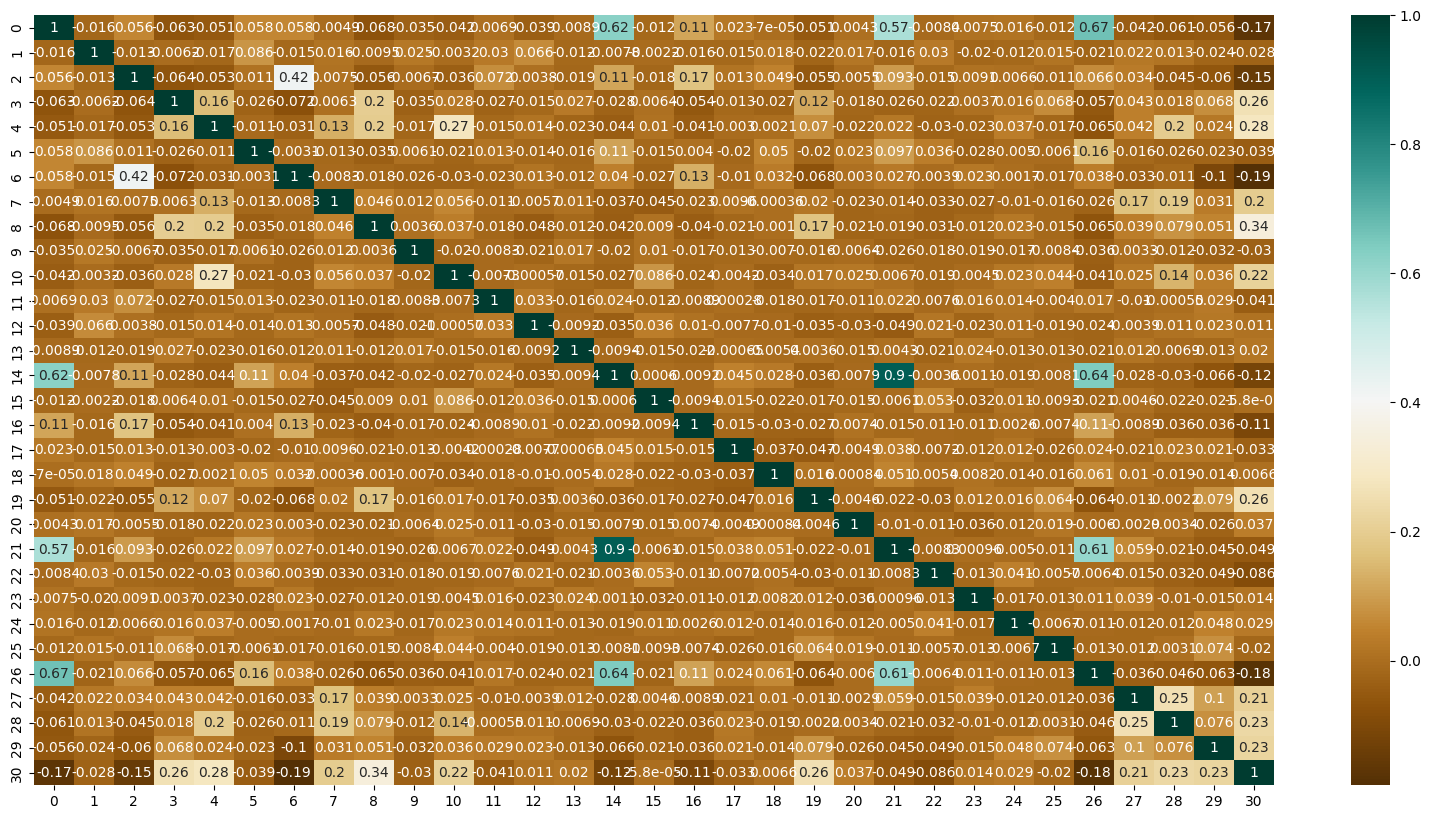

In [4]:
pl.figure(figsize=(20,10));
c= df.corr();
sns.heatmap(c,cmap="BrBG",annot=True)

This heatmap helps us get a sense of the data and what variables may be correlated. Just looking at the data, it seems that perhaps a decision tree based model could work - perhaps in conjuction with an ensemble model

In [3]:
data = np.loadtxt('spamTrain1.csv',delimiter=',')

# Randomly shuffle rows of data set then separate labels (last column)
np.random.seed(1)
shuffleIndex = np.arange(np.shape(data)[0])
np.random.shuffle(shuffleIndex)
data = data[shuffleIndex,:]
features = data[:,:-1]
labels = data[:,-1]


# Arbitrarily choose all odd samples as train set and all even as test set
# then compute test set AUC for model trained only on fixed train set
# Code from Kevin S. Xu
trainFeatures = features[0::2,:]
trainLabels = labels[0::2]
testFeatures = features[1::2,:]
testLabels = labels[1::2]

Optimal number of features : 16
Optimal features: [ True False  True  True  True False  True  True  True False  True False
 False False  True False  True False False  True False False  True False
 False False  True  True  True  True]


/Users/prateekdullur/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


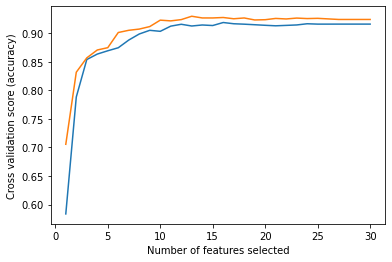

In [6]:
# Define xgb classifier
clf = xgb.XGBClassifier(max_depth=4, eta=0.1, max_bin=256, n_estimators=100, objective='binary:logistic')
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(2),
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(features, labels)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Optimal features: {}".format(rfecv.support_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [7]:
trainFeaturesRFE = rfecv.fit_transform(trainFeatures, trainLabels)
testFeaturesRFE = rfecv.transform(testFeatures)
clf.fit(trainFeaturesRFE, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeaturesRFE,trainLabels,testFeaturesRFE)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))

Test set AUC:  0.9214876632274999


First, let's try an SVM model. We can use Grid Search to find the best parameters for the classifier

In [6]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)
print("10-fold cross-validation mean AUC: ", np.mean(aucCV(trainFeatures,trainLabels, model=svm)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
10-fold cross-validation mean AUC:  0.9081598089843969


In [8]:
# fitting the model for grid search
svm.fit(trainFeatures, trainLabels)
print("Best parameters:{}".format(svm.best_params_))

NameError: name 'svm' is not defined

In [8]:
clf = SVC(C=1000, gamma=1, kernel='rbf', probability=True)
# Fit classifier to training data
clf.fit(trainFeatures, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeatures,trainLabels,testFeatures, model=clf)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))

TypeError: predictTest() got an unexpected keyword argument 'model'

Okay, not bad. The Naive Bayes' classifier had a test set accuracy of 0.83, so we're already seeing a significant improvement

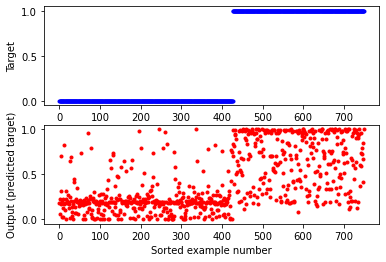

In [ ]:
# Examine outputs compared to labels (code from Kevin S. Xu)
sortIndex = np.argsort(testLabels)
nTestExamples = testLabels.size
plt.subplot(2,1,1)
plt.plot(np.arange(nTestExamples),testLabels[sortIndex],'b.')
plt.xlabel('Sorted example number')
plt.ylabel('Target')
plt.subplot(2,1,2)
plt.plot(np.arange(nTestExamples),testOutputs[sortIndex],'r.')
plt.xlabel('Sorted example number')
plt.ylabel('Output (predicted target)')
plt.show()

Let's now try an XGBoost classifier (as defined by Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM. https://doi.org/10.1145/2939672.2939785)

In order to run this model, your python kernel will need the xgboost package, which is available through pip install xgboost

In [ ]:
# Define xgb classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=multiprocessing.cpu_count() // 2)
clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],'n_estimators': [50, 100, 200], 'eta':[0.01, 0.1, 0.3, 1], 'max_bin':[256,512]}, verbose=1, n_jobs=2)
# Evaluating classifier accuracy using 10-fold cross-validation
print("10-fold cross-validation mean AUC: ", np.mean(aucCV(trainFeatures,trainLabels, model=clf)))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
10-fold cross-validation mean AUC:  0.9267818868343607


In [ ]:
clf.fit(trainFeatures, trainLabels)
print("Best parameters:{}".format(clf.best_params_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters:{'eta': 0.1, 'max_bin': 256, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
clf = xgb.XGBClassifier(max_depth=4, eta=0.1, max_bin=256, n_estimators=100, objective='binary:logistic')    
# Fit classifier to training data
clf.fit(trainFeatures, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeatures,trainLabels,testFeatures, model=clf)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))

TypeError: predictTest() got an unexpected keyword argument 'model'

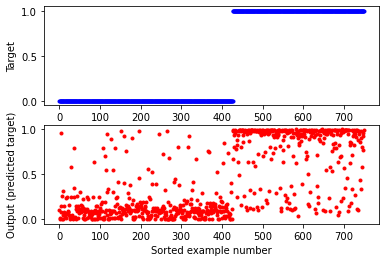

In [ ]:
# Examine outputs compared to labels (code from Kevin S. Xu)
sortIndex = np.argsort(testLabels)
nTestExamples = testLabels.size
plt.subplot(2,1,1)
plt.plot(np.arange(nTestExamples),testLabels[sortIndex],'b.')
plt.xlabel('Sorted example number')
plt.ylabel('Target')
plt.subplot(2,1,2)
plt.plot(np.arange(nTestExamples),testOutputs[sortIndex],'r.')
plt.xlabel('Sorted example number')
plt.ylabel('Output (predicted target)')
plt.show()

A gradient boosted ensemble decision tree model appears to be the most effective (at least compared to SVM and Naive Bayes)

Let's try a random forest algorithm

In [17]:
#Create a Gaussian Classifier
rf=RandomForestClassifier()

# Create the random grid
random_grid = {    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200, 1000]}

# Define classifier
clf = GridSearchCV(rf, random_grid, verbose=1, n_jobs=2)
# Evaluating classifier accuracy using 10-fold cross-validation
print("10-fold cross-validation mean AUC: ", np.mean(aucCV(trainFeatures,trainLabels, model=clf)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
10-fold cross-validation mean AUC:  0.9134975845410628


In [18]:
clf.fit(trainFeatures, trainLabels)
print("Best parameters:{}".format(clf.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:{'bootstrap': True, 'max_depth': 100, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}


In [4]:
best_params = {'bootstrap': True, 'max_depth': 100, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}
clf = RandomForestClassifier(**best_params)  
# Fit classifier to training data
clf.fit(trainFeatures, trainLabels)
# Test on testing set
testOutputs = predictTest(trainFeatures,trainLabels,testFeatures, model=clf)
print("Test set AUC: ", roc_auc_score(testLabels,testOutputs))

Test set AUC:  0.9240543499539592


# Real-World Evaluation

<font color=red>From assignment: "Recommendations on how to evaluate the effectiveness of your algorithm if it were to be deployed as a personalized spam filter for a user. What might be a good choice of metric, and what are the implications on the classifier? How might you solicit feedback from users to evaluate and improve your spam filter? (10 points)"</font>

Properties of an optimal spam filter in the real world would be one that recognizes the all spam emails as spam, but never sends non-spam emails to the spam folder. In other words, the filter should have an extremely high true positive rate and an extremely low false positive rate. However, it is arguably more important that a spam filter prioritize a low false positive rate over having a high true positive rate, as sending a non-spam email to the spam folder could result in someone missing critical information, while a spam email not being filtered typically just results in a minor annoyance. To evaluate the effectiveness of a spam filter, one should consider both the true positive and false positive rates, but with more focus put on the false positive rate. As such, considering the true positive rate at a low false positive rate (such as 1%, like was done to evaluate our submitted model) may be an effective way to evaluate our classifier in relation to other options. 

Exactly how important it is for the spam filter to avoid classifying non-spam as spam depends on the individual user, so to create the best spam filter possible, it would be important to include an "agressiveness" setting, which can be set by the user. This setting would affect the false positive rate of the filter, and could be implemented by using multiple models for different filters. The most agressive filter would likely have a higher false positive rate (as it would air on the side of sending things to spam) while the least agressive setting would likely have a lower false positive rate (as it would air on the side of not sending things to spam).

To improve the spam filter further, a feature could be implemented such that when a spam email is opened or manually sent to the their primary inbox, this information is sent back to the organization responsible for the filter. This email would be considered a false positive. Similarly, when an email is manually sent to the spam folder, it is recognized as a false negative. This information could be used to get real-world statistics regarding how the filter is performing...
